In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *

In [3]:
torch.cuda.set_device(2)

In [4]:
bs = 64  
mypath=Path('/data2/itahir/MedstarProject')

In [5]:
data_lm = load_data(mypath, 'p_all_data_lm2.pkl', bs=bs)

/data2/itahir/anaconda3/lib/python3.7/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.loss.CrossEntropyLoss' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


# Data Split

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

In [8]:
split=StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)

In [9]:
df=pd.read_csv('data_step2_all.csv')

In [10]:
df.head()

,Unnamed: 0,Path,Notes,File name,text,label
0,0,Benign,NaN,9ae0ad5a60c745805466caa5dd4e29a7.txt,Source of Specimen\nA\tLeft Breast Cyst (9 o'c...,Benign
1,1,Benign,NaN,ed607e409c73353f0d0ab94d5cca1b6e.txt,Source of Specimen\nA\tRight breast cores\nB\t...,Benign
2,2,Benign,NaN,fbf2e75883507455721fa410cefe8213.txt,"Addendum\nAfter discussion with a radiologist,...",Benign
3,3,Benign,NaN,6aaec96d9a3c31aa9711bc453dbaea73.txt,Source of Specimen\nA\tRight breast core bx\nC...,Benign
4,4,Benign,NaN,7c6a5ffcad9f0b91b4189c2a504c4a42.txt,Source of Specimen\nA\tRight breast cores with...,Benign


In [11]:
df.drop('Unnamed: 0', axis=1,inplace=True)

In [12]:
df.head()

,Path,Notes,File name,text,label
0,Benign,NaN,9ae0ad5a60c745805466caa5dd4e29a7.txt,Source of Specimen\nA\tLeft Breast Cyst (9 o'c...,Benign
1,Benign,NaN,ed607e409c73353f0d0ab94d5cca1b6e.txt,Source of Specimen\nA\tRight breast cores\nB\t...,Benign
2,Benign,NaN,fbf2e75883507455721fa410cefe8213.txt,"Addendum\nAfter discussion with a radiologist,...",Benign
3,Benign,NaN,6aaec96d9a3c31aa9711bc453dbaea73.txt,Source of Specimen\nA\tRight breast core bx\nC...,Benign
4,Benign,NaN,7c6a5ffcad9f0b91b4189c2a504c4a42.txt,Source of Specimen\nA\tRight breast cores with...,Benign


In [13]:
for train_index, test_index in split.split(df,df['label']):
    train=df.loc[train_index]
    test=df.loc[test_index]

# Classifier

In [17]:
data_clas = TextDataBunch.from_df(path=mypath, train_df=train, valid_df=test, text_cols=['text'], label_cols='label', 
                                  vocab=data_lm.vocab)

In [40]:
data_clas.save('stepwise_all_data_clas.pkl')

In [14]:
data_clas = load_data(mypath, 'stepwise_all_data_clas.pkl', bs=bs)

/data2/itahir/anaconda3/lib/python3.7/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.loss.CrossEntropyLoss' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [15]:
kappa = KappaScore()
kappa.weights = "quadratic"

In [16]:
train['label'].value_counts()

Benign        1937
Benign,HRL     239
Name: label, dtype: int64

In [16]:
(1937/(1937+239),239/(1937+239))

(0.8901654411764706, 0.10983455882352941)

In [18]:
1/(0.9), 1/(0.1)

(1.1111111111111112, 10.0)

In [17]:
w = torch.cuda.FloatTensor([1.1, 10])

In [18]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.3,metrics=[kappa, accuracy, error_rate],loss_func=torch.nn.CrossEntropyLoss(weight=w))
learn.load_encoder('p_all_fine_tuned_enc_6'); #p_all_fine_tuned_enc_6

In [41]:
learn.load('p_all_fourth_00');

In [42]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


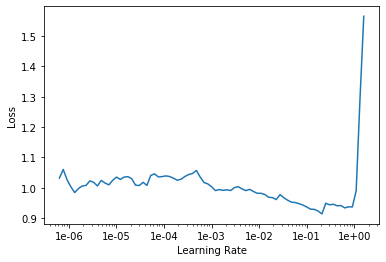

In [43]:
learn.recorder.plot()

In [45]:
learn.fit_one_cycle(1, slice(1e-6,1e-1), moms=(0.8,0.7)) 

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.762530,0.728296,0.330223,0.825368,0.174632,00:09


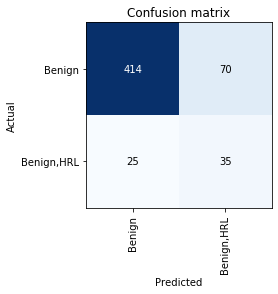

In [46]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [47]:
learn.save('w_step_all_first-00')

In [48]:
learn.load('w_step_all_first-00');

In [49]:
learn.freeze_to(-2)

In [50]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


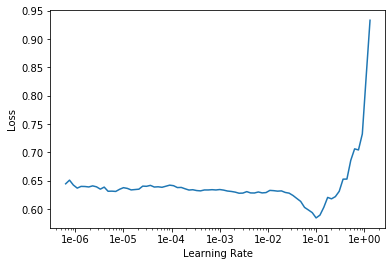

In [51]:
learn.recorder.plot()

In [52]:
learn.fit_one_cycle(4, slice(1e-6,1e-1), moms=(0.8,0.7))

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.606735,0.568109,0.472072,0.867647,0.132353,00:11
1,0.484326,0.433519,0.509177,0.871324,0.128676,00:11
2,0.388050,0.326041,0.665260,0.922794,0.077206,00:11
3,0.297098,0.320965,0.668858,0.926471,0.073529,00:11


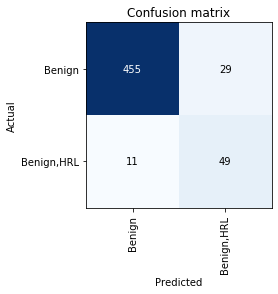

In [53]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [54]:
learn.save('w_step_all_second-00')

In [55]:
learn.fit_one_cycle(4, slice(1e-6/3,1e-1/3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.201067,0.311918,0.638651,0.909926,0.090074,00:11
1,0.200085,0.352575,0.663560,0.920956,0.079044,00:11
2,0.188430,0.302520,0.701972,0.933824,0.066176,00:11
3,0.164781,0.320039,0.691704,0.931985,0.068015,00:11


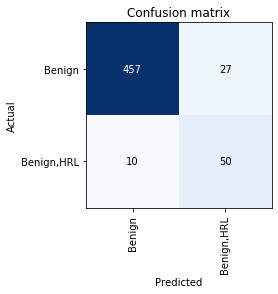

In [56]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [57]:
learn.save('w_b_step_all_second-00')

In [69]:
learn.load('w_b_step_all_second-00');

In [70]:
learn.unfreeze()

In [71]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


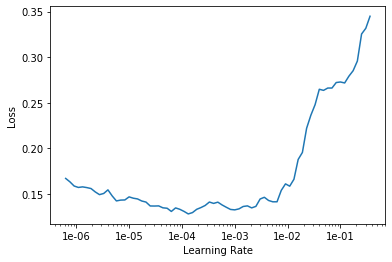

In [72]:
learn.recorder.plot()

In [74]:
learn.fit_one_cycle(1, slice(1e-5,1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.130610,0.345904,0.731623,0.941176,0.058824,00:18


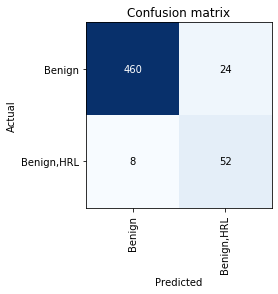

In [75]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [77]:
learn.save('w_step_all_third-00');

In [19]:
data_clas = load_data(mypath, 'stepwise_all_data_clas_corrected.pkl', bs=bs)

In [20]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.3,metrics=[kappa, accuracy, error_rate],loss_func=torch.nn.CrossEntropyLoss(weight=w))
learn.load_encoder('p_all_fine_tuned_enc_6'); #p_all_fine_tuned_enc_6

In [21]:
learn.load('w_step_all_third-00');

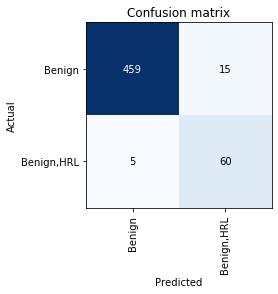

In [81]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [23]:
learn.path

PosixPath('/data2/itahir/MedstarProject')

In [24]:
learn.export(file='export2-weightedloss.pkl')